# Forecasting bandwidth usage for data centers

### Problem statement

Suppose that you are tasked with predicting bandwidth usage for a large data center.
Bandwidth is defined as the maximum rate of data that can be transferred. Its base
unit is bits per second (bps).
Forecasting bandwidth usage allows data centers to better manage their computing resources. In the case where less bandwidth usage is expected, they can shut down
some of their computing resources. This in turns reduces expenses and allows for
maintenance. On the other hand, if bandwidth usage is expected to increase, they can
dedicate the required resources to sustain the demand and ensure low latency, thus
keeping their customers satisfied.

**Autoregressive moving average process**  
The autoregressive moving average process is a combination of the autoregressive
process and the moving average process.
It is denoted as **ARMA(p,q)**, where p is the order of the autoregressive process, and
q is the order of the moving average process. The general equation of the ARMA(p,q)
model is  
$y_t = C + φ_1y_{t–1} + φ_2y_{t–2} +⋅⋅⋅+ φ_py_{t–p} + µ + ϵ_t + θ_1ϵ_{t–1} + θ_2ϵ_{t–2} +⋅⋅⋅+ θ_qϵ_{t–q}$  
An ARMA(0,q) process is equivalent to an MA(q) process, since the order p = 0 cancel the AR(p) portion. An ARMA(p,0) process is equivalent to an AR(p) process, since
the order q = 0 cancels the MA(q) portion.

## Identifying a stationary ARMA process

$yt = 0.33y_{t –1} + 0.9ϵ_{t –1} + ϵ_t$ 

In [1]:
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
np.random.seed(42)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(ARMA_1_1)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042705
p-value: 1.707846668009557e-08


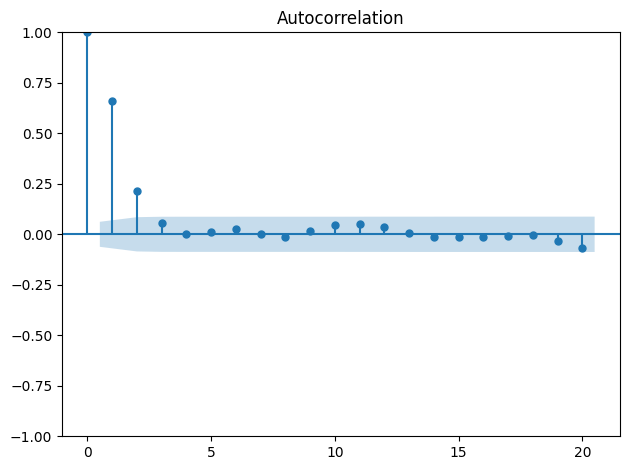

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ARMA_1_1, lags=20);
plt.tight_layout()

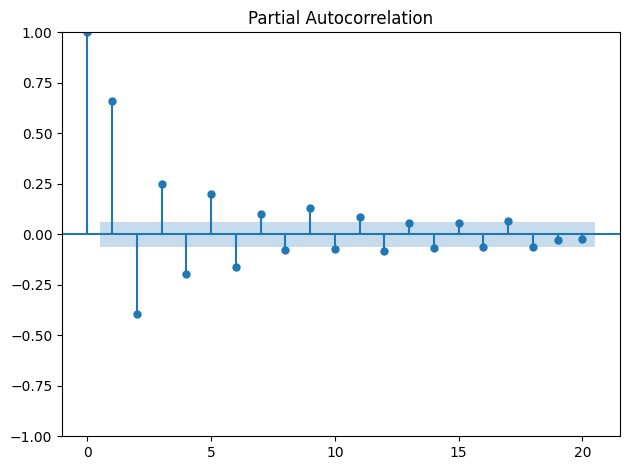

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ARMA_1_1, lags=20);
plt.tight_layout()

**Identifying a stationary ARMA(p,q) process**  
If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal pattern, then it is a stationary ARMA(p,q) process.

**Akaike information criterion (AIC)**  
The Akaike information criterion (AIC) is a measure of the quality of a model in relation to other models. It is used for model selection.
The AIC is a function of the number of parameters k in a model and the maximum
value of the likelihood function :
The lower the value of the AIC, the better the model. Selecting according to the AIC
allows us to keep a balance between the complexity of a model and its goodness of
fit to the data.

In [11]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))

In [12]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

In [13]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), 
                            simple_differencing=False).fit(disp=False)
        
        except:
            continue
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [14]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

/tmp/ipykernel_29154/2073639510.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/home/nnaemeka/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nnaemeka/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nnaemeka/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.161528
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


**Quantile-quantile plot (Q-Q plot).**  
A Q-Q plot is a plot of the quantiles of two distributions against each other. In time
series forecasting, we plot the distribution of our residuals on the y-axis against the
theoretical normal distribution on the x-axis.
This graphical tool allows to us to assess the goodness of fit of our model. If the distribution of our residuals is similar to a normal distribution, we will see a straight line
lying on y = x. This means that our model is a good fit, because the residuals are
similar to white noise.
On the other hand, if the distribution of our residuals is different from a normal dis-
tribution, we will see a curved line. We can then conclude that our model is not a good
fit, since the residuals’ distribution is not close to a normal distribution, and therefore
the residuals are not similar to white noise.

**Ljung-Box test.**  
The Ljung-Box test is a statistical test that determines whether the autocorrelation of
a group of data is significantly different from 0.
In time series forecasting, we apply the Ljung-Box test on the model’s residuals to
test whether they are similar to white noise. The null hypothesis states that the data
is independently distributed, meaning that there is no autocorrelation. If the p-value
is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals
are independently distributed. Therefore, there is no autocorrelation, the residuals
are similar to white noise, and the model can be used for forecasting.If the p-value is less than 0.05, we reject the null hypothesis, meaning that our resid-
uals are not independently distributed and are correlated. The model cannot be used
for forecasting.

In [15]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

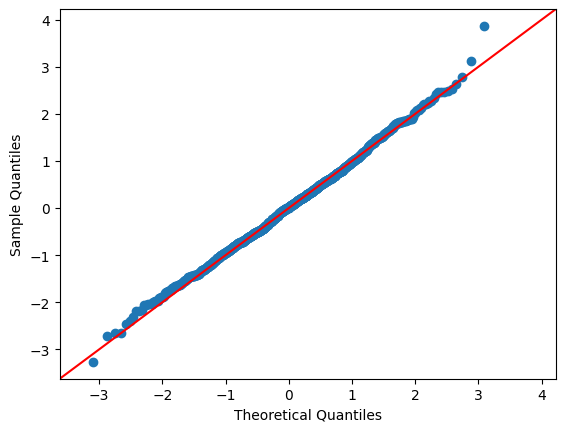

In [16]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45');

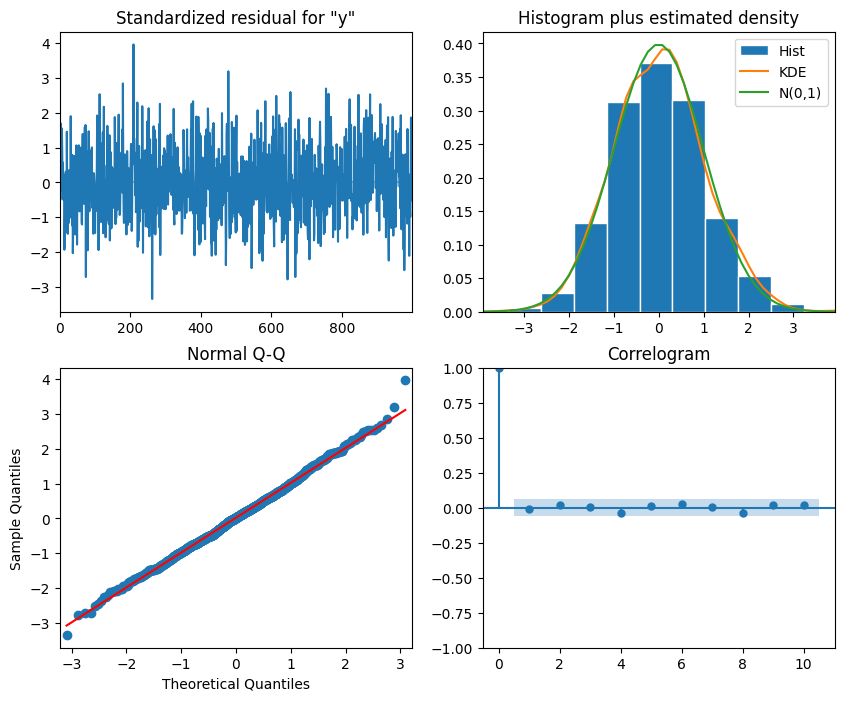

In [17]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
values = acorr_ljungbox(residuals, np.arange(1, 11, 1))
values.iloc[:,1]

1     0.860897
2     0.767966
3     0.909817
4     0.721089
5     0.810385
6     0.821750
7     0.894063
8     0.817501
9     0.852419
10    0.874093
Name: lb_pvalue, dtype: float64

## Real world example

In [23]:
import pandas as pd
df = pd.read_csv('../data/bandwidth.csv')

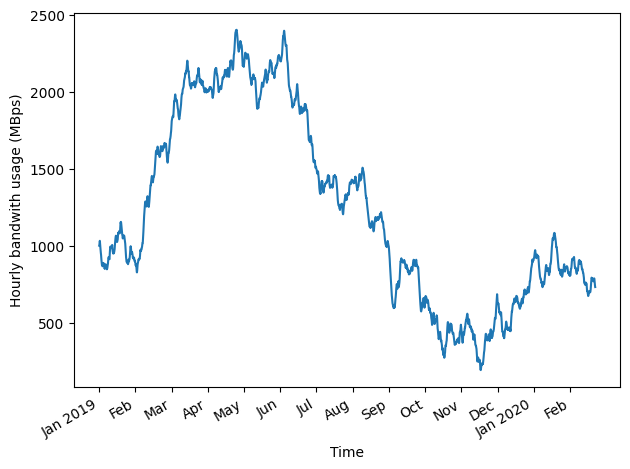

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df.hourly_bandwidth)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
plt.xticks(
np.arange(0, 10000, 730),
['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',  'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
plt.tight_layout()

In [26]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df['hourly_bandwidth'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# Therefore, we cannot reject the null hypothesis, meaning that our time series is not stationary

ADF Statistic: -0.8714653199452883
p-value: 0.7972240255014503


In [27]:
import numpy as np
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

In [28]:
ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789017
p-value: 0.0


In [29]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})
train = df_diff[:-168]
test = df_diff[-168:]
print(len(train))
print(len(test))

9831
168


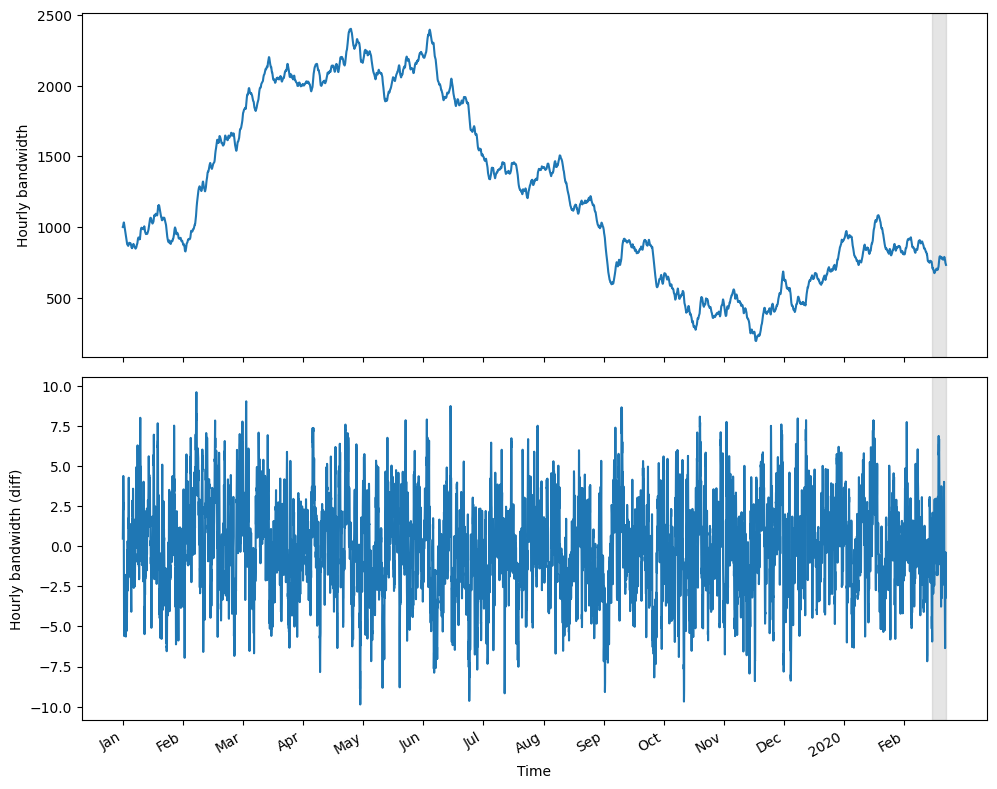

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
ax1.plot(df.hourly_bandwidth)
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax2.plot(df_diff.bandwidth_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth (diff)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)
plt.xticks(
np.arange(0, 10000, 730),
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])
fig.autofmt_xdate()
plt.tight_layout()

In [32]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

/tmp/ipykernel_29154/2073639510.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/home/nnaemeka/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nnaemeka/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nnaemeka/miniconda3/envs/pytorch/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


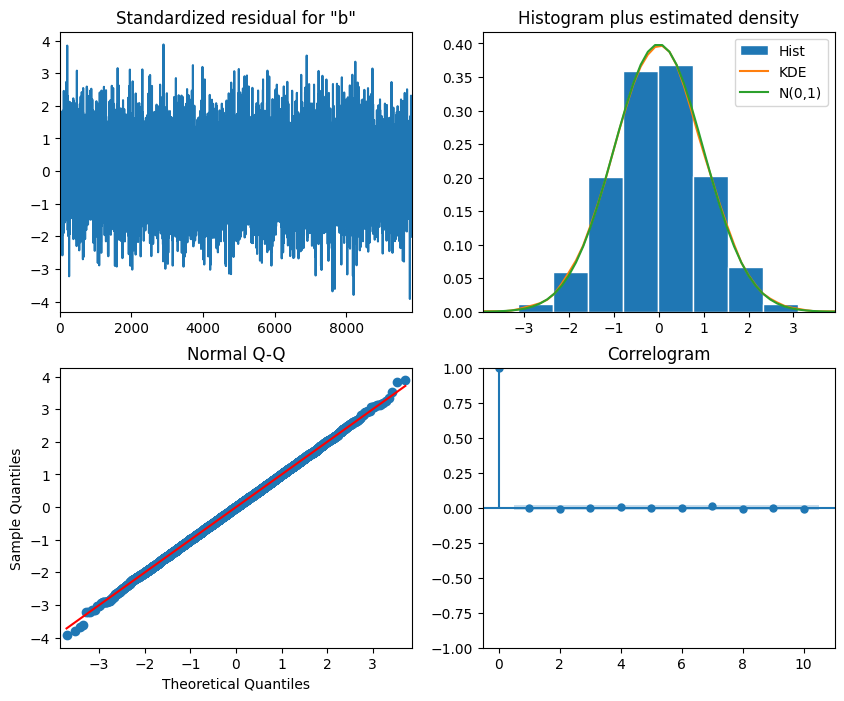

In [33]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));

In [34]:
residuals = model_fit.resid
values = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(values.iloc[:,1])

1     0.837257
2     0.811247
3     0.914416
4     0.931545
5     0.973678
6     0.981019
7     0.952607
8     0.919067
9     0.953615
10    0.964015
Name: lb_pvalue, dtype: float64


In [35]:
def recursive_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == "mean":
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    elif method == "last":
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == "ARMA":
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window -1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR


In [37]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
pred_mean = recursive_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = recursive_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = recursive_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')
test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA
pred_df.head()

/tmp/ipykernel_29154/3650049479.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
/tmp/ipykernel_29154/3650049479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
/tmp/ipykernel_29154/3650049479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,bandwidth_diff
9831,-5.943995
9832,-5.865194
9833,-3.197066
9834,-1.090197
9835,0.665291


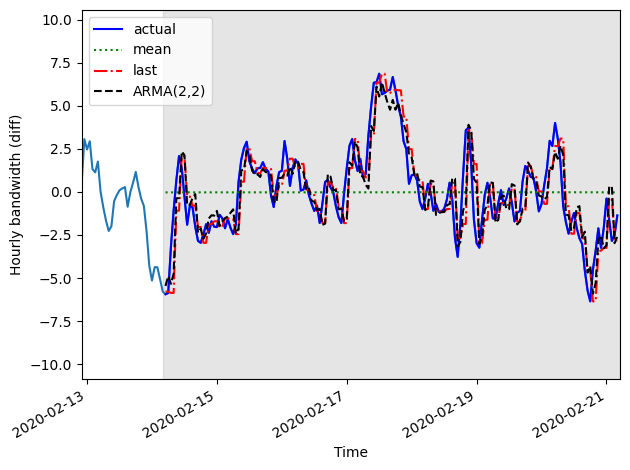

In [38]:
fig, ax = plt.subplots()
ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')
ax.axvspan(9830, 9999, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)
plt.xticks(
[9802, 9850, 9898, 9946, 9994],
['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
plt.tight_layout()

In [39]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.769046211418683


In [41]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] +  test['pred_ARMA'].cumsum()

/tmp/ipykernel_29154/3583454463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] +  test['pred_ARMA'].cumsum()


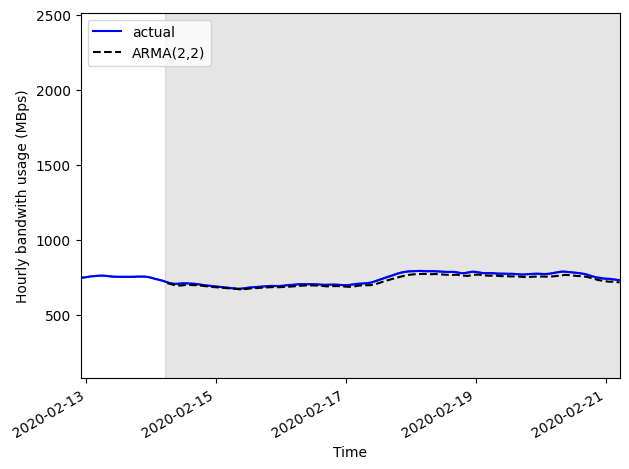

In [42]:
fig, ax = plt.subplots()
ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)
plt.xticks(
[9802, 9850, 9898, 9946, 9994],
['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
plt.tight_layout()

In [43]:
from sklearn.metrics import mean_absolute_error
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])
print(mae_ARMA_undiff)

14.000362772710762
